# Comprehensive Local and Global SHAP Analysis for Stacking Model

This notebook performs a robust analysis of the Stacking Classifier, focusing on:
1.  **Global Interpretability**: How much each base model contributes to the final decision.
2.  **Local Interpretability**: Why a specific decision was made for individual cases (Waterfall/Force plots).

We explicitly handle the meta-features (predictions of base models) to ensure SHAP values are calculated correctly.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
import joblib
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
import shap

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
# Load Validation Data
print("Loading validation data...")
try:
    df_val = pd.read_csv('val_selected.csv')
    X_val = df_val.drop('target', axis=1)
    y_val = df_val['target']
    print(f"Validation data loaded. Shape: {X_val.shape}")
except FileNotFoundError:
    print("Warning: 'val_selected.csv' not found. Trying 'test_selected.csv'...")
    try:
        df_val = pd.read_csv('test_selected.csv')
        X_val = df_val.drop('target', axis=1)
        y_val = df_val['target']
        print(f"Test data loaded as validation. Shape: {X_val.shape}")
    except FileNotFoundError:
        print("Error: Neither 'val_selected.csv' nor 'test_selected.csv' found.")

In [2]:
# Load Models
print("Loading models...")

# 1. XGBoost
try:
    xgb_model = xgb.Booster()
    xgb_model.load_model("models/xgb_booster.model")
    print("XGBoost loaded successfully.")
except Exception as e:
    print(f"Error loading XGBoost: {e}")

# 2. LightGBM
try:
    lgb_model = joblib.load("models/lgb_model.joblib")
    print("LightGBM loaded successfully.")
except Exception as e:
    print(f"Error loading LightGBM: {e}")

# 3. CatBoost
try:
    cat_model = CatBoostClassifier()
    cat_model.load_model("models/cat_clf.cbm")
    print("CatBoost loaded successfully.")
except Exception as e:
    print(f"Error loading CatBoost: {e}")

# 4. Meta Model (Stacking)
try:
    meta_model = joblib.load("models/meta_model.joblib")
    print("Meta-model loaded successfully.")
except Exception as e:
    print(f"Error loading Meta-model: {e}")

Loading models...
XGBoost loaded successfully.
LightGBM loaded successfully.
CatBoost loaded successfully.
Meta-model loaded successfully.


/tmp/ipykernel_252522/364020622.py:7: UserWarning: [01:33:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/c_api/c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  xgb_model.load_model("models/xgb_booster.model")


In [3]:
# Generate Predictions from Base Models (Meta-Features)
print("Generating base model predictions...")

# XGBoost
dval = xgb.DMatrix(X_val)
xgb_pred = xgb_model.predict(dval)

# LightGBM
# Check if lgb_model is a Booster or Sklearn wrapper
if hasattr(lgb_model, 'predict_proba'):
    lgb_pred = lgb_model.predict_proba(X_val)[:, 1]
else:
    lgb_pred = lgb_model.predict(X_val)

# CatBoost
cat_pred = cat_model.predict_proba(X_val)[:, 1]

# Create Meta-Features DataFrame
meta_X_val = pd.DataFrame({
    'XGBoost': xgb_pred,
    'LightGBM': lgb_pred,
    'CatBoost': cat_pred
})

print("Meta-features head:")
print(meta_X_val.head())

# Verify Meta-Model Performance
if hasattr(meta_model, 'predict_proba'):
    meta_pred = meta_model.predict_proba(meta_X_val)[:, 1]
else:
    meta_pred = meta_model.predict(meta_X_val)

auc = roc_auc_score(y_val, meta_pred)
print(f"\nStacking Model AUC on Validation Set: {auc:.4f}")

Generating base model predictions...


NameError: name 'X_val' is not defined

In [13]:
# Initialize LIME Explainer for Meta-Model

print("Initializing LIME Explainer...")

# Define the prediction function for LIME
# LIME passes a numpy array, but our meta-model might expect a DataFrame with specific column names
def predict_fn(x):
    # Ensure input is a DataFrame with correct column names
    if isinstance(x, np.ndarray):
        df = pd.DataFrame(x, columns=meta_X_val.columns)
    else:
        df = x
    return meta_model.predict_proba(df)

# Initialize the explainer
# We use the validation set statistics for discretization
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=meta_X_val.values,
    feature_names=meta_X_val.columns.tolist(),
    class_names=['No Default', 'Default'],
    mode='classification',
    verbose=True,
    random_state=42
)

print("LIME Explainer initialized.")

Initializing LIME Explainer...
LIME Explainer initialized.


# Global Analysis: PDP and ICE Plots
Partial Dependence Plots (PDP) show the marginal effect of a feature on the predicted outcome.
Individual Conditional Expectation (ICE) plots visualize the dependence of the prediction on a feature for each instance separately, allowing us to see if the model behaves differently for different samples.

Generating PDP and ICE plots...


/home/wojtek/anaconda3/envs/ML2/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/wojtek/anaconda3/envs/ML2/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/wojtek/anaconda3/envs/ML2/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/wojtek/anaconda3/envs/ML2/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/wojtek/anaconda3/envs/ML2/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/wojt

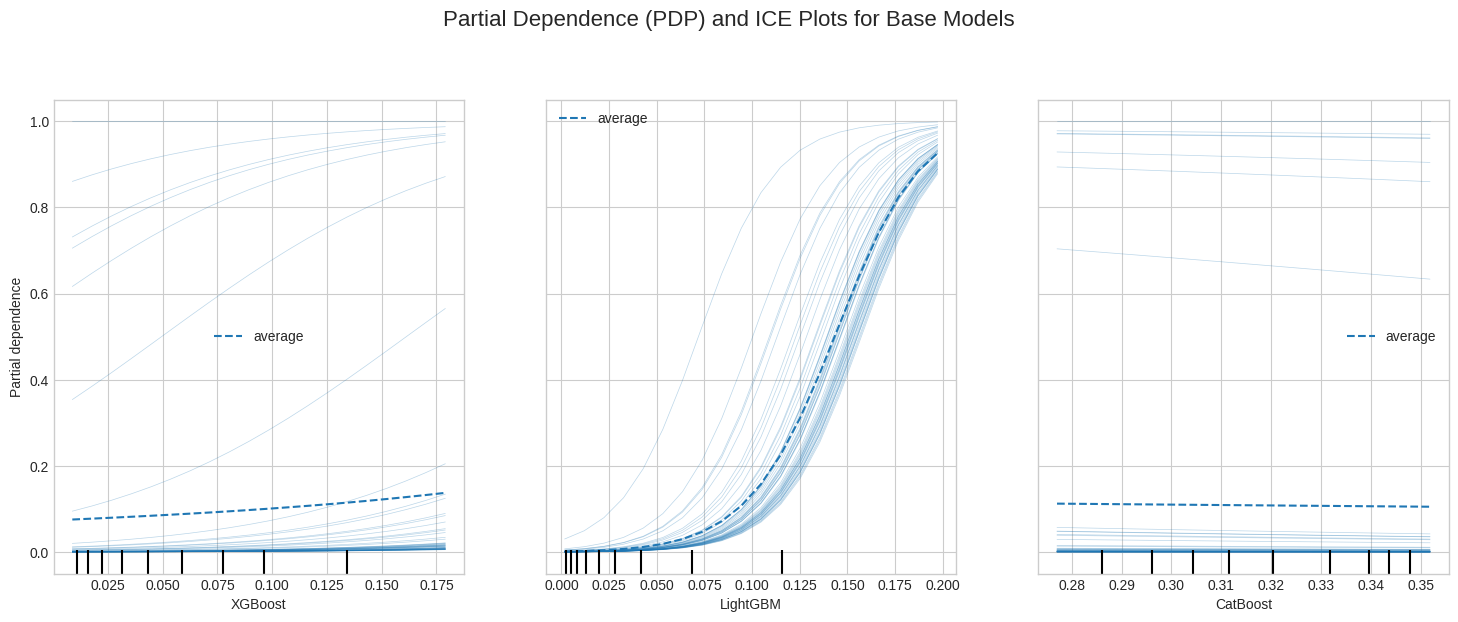

In [17]:
from sklearn.inspection import PartialDependenceDisplay

print("Generating PDP and ICE plots...")

# We plot PDP and ICE for all 3 meta-features
features_to_plot = ['XGBoost', 'LightGBM', 'CatBoost']

fig, ax = plt.subplots(figsize=(18, 6))

# subsample=50: Selects 50 random lines for ICE to keep the plot readable
# kind='both': Plots both the individual ICE lines and the average PDP line
PartialDependenceDisplay.from_estimator(
    meta_model,
    meta_X_val,
    features_to_plot,
    kind='both',
    subsample=50, 
    grid_resolution=20,
    random_state=42,
    ax=ax
)

plt.suptitle("Partial Dependence (PDP) and ICE Plots for Base Models", fontsize=16, y=1.05)
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
# Centered ICE Plots (c-ICE)
# c-ICE plots center the curves at the first value of the feature, making it easier to compare shapes.

print("Generating Centered ICE plots...")

features_to_plot = ['XGBoost', 'LightGBM', 'CatBoost']
fig, ax = plt.subplots(figsize=(18, 6))

PartialDependenceDisplay.from_estimator(
    meta_model,
    meta_X_val,
    features_to_plot,
    kind='individual',
    centered=True,
    subsample=50,
    grid_resolution=20,
    random_state=42,
    ax=ax
)

plt.suptitle("Centered ICE Plots (c-ICE) for Base Models", fontsize=16, y=1.05)
plt.subplots_adjust(top=0.9)
plt.show()

# Global Analysis: SHAP
SHAP (SHapley Additive exPlanations) assigns each feature an importance value for a particular prediction.
**Summary Plot**: Shows the global importance of each feature and its impact on the model output.
**Dependence Plot**: Shows the relationship between a feature's value and its SHAP value.

Initializing SHAP Explainer...
Using LinearExplainer
SHAP values shape: (600, 3)


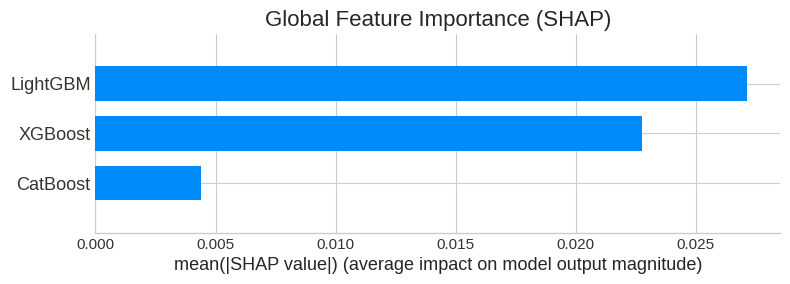

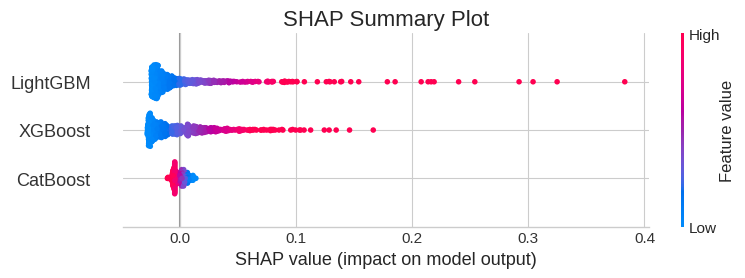

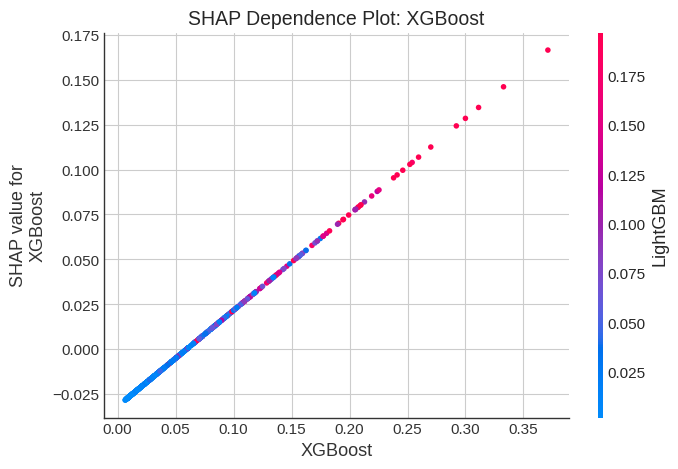

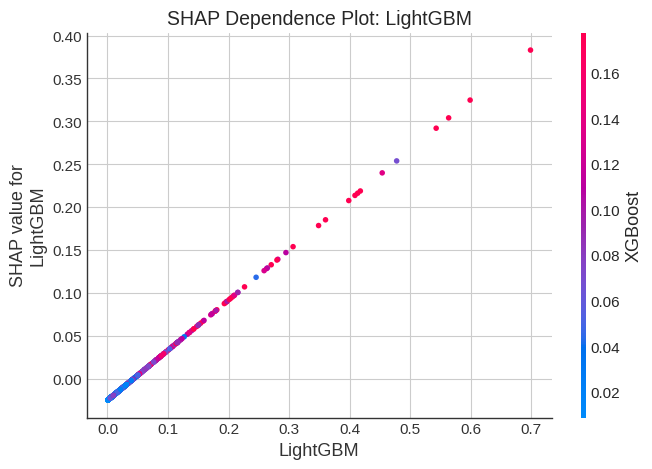

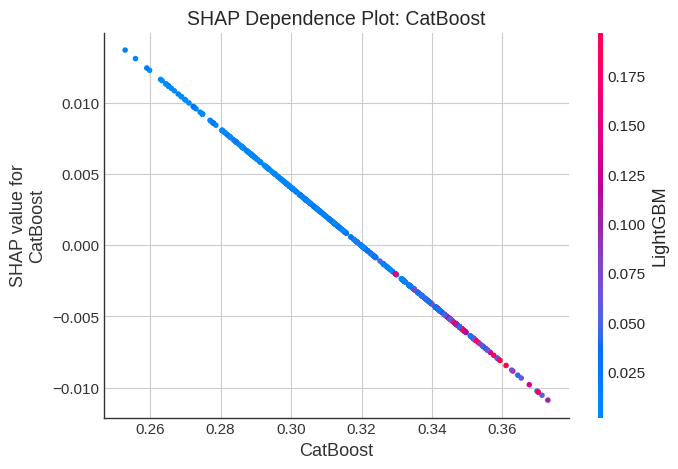

In [18]:
# Initialize SHAP Explainer for Global Analysis
print("Initializing SHAP Explainer...")

# Extract the final estimator if it's a pipeline
if hasattr(meta_model, 'named_steps'):
    final_estimator = meta_model.named_steps['classifier'] if 'classifier' in meta_model.named_steps else meta_model.steps[-1][1]
else:
    final_estimator = meta_model

# Use LinearExplainer for Logistic Regression (common in Stacking)
masker = shap.maskers.Independent(data=meta_X_val)
try:
    shap_explainer = shap.LinearExplainer(final_estimator, masker=masker)
    shap_values_global = shap_explainer(meta_X_val)
    print("Using LinearExplainer")
except Exception as e:
    print(f"LinearExplainer failed ({e}), falling back to generic Explainer")
    shap_explainer = shap.Explainer(final_estimator, masker=masker)
    shap_values_global = shap_explainer(meta_X_val)

print(f"SHAP values shape: {shap_values_global.shape}")

# SHAP Summary Plots
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_global, meta_X_val, plot_type="bar", show=False)
plt.title("Global Feature Importance (SHAP)", fontsize=16)
plt.show()

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_global, meta_X_val, show=False)
plt.title("SHAP Summary Plot", fontsize=16)
plt.show()

# SHAP Dependence Plots
for feature in meta_X_val.columns:
    shap.dependence_plot(feature, shap_values_global.values, meta_X_val, show=False)
    plt.title(f"SHAP Dependence Plot: {feature}", fontsize=14)
    plt.show()


Case: Highest Risk (Index: 252)
Prediction: 1.0000
Actual: 1
Intercept -0.008334073511421042
Prediction_local [0.68911609]
Right: 0.9999999999998403


/home/wojtek/anaconda3/envs/ML2/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


<Figure size 1000x400 with 0 Axes>

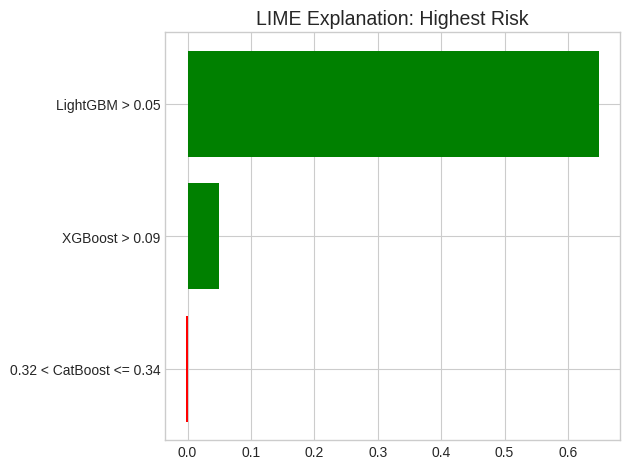


Case: Lowest Risk (Index: 408)
Prediction: 0.0004
Actual: 0
Intercept 0.22754947319930408
Prediction_local [-0.0067568]
Right: 0.00043511588527454803


/home/wojtek/anaconda3/envs/ML2/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


<Figure size 1000x400 with 0 Axes>

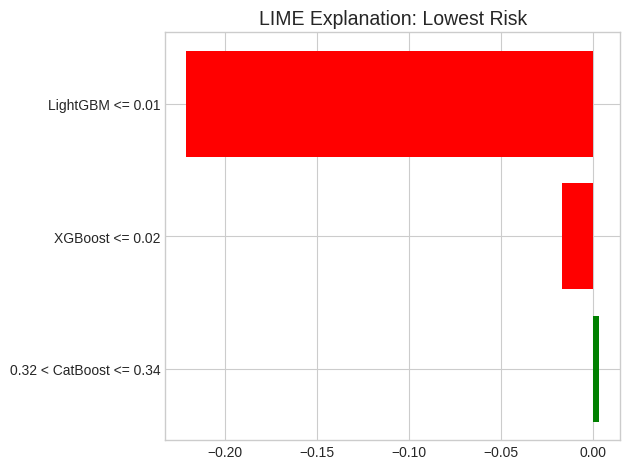


Case: False Positive (Index: 462)
Prediction: 1.0000
Actual: 0
Intercept -0.007641335065235039
Prediction_local [0.70935143]
Right: 0.9999999999978955


/home/wojtek/anaconda3/envs/ML2/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


<Figure size 1000x400 with 0 Axes>

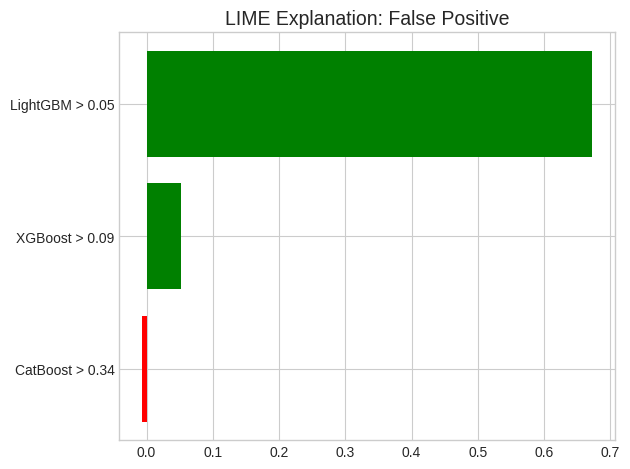


Case: False Negative (Index: 51)
Prediction: 0.0005
Actual: 1


/home/wojtek/anaconda3/envs/ML2/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Intercept 0.22863554909961592
Prediction_local [-0.01424841]
Right: 0.0004865615551642336


<Figure size 1000x400 with 0 Axes>

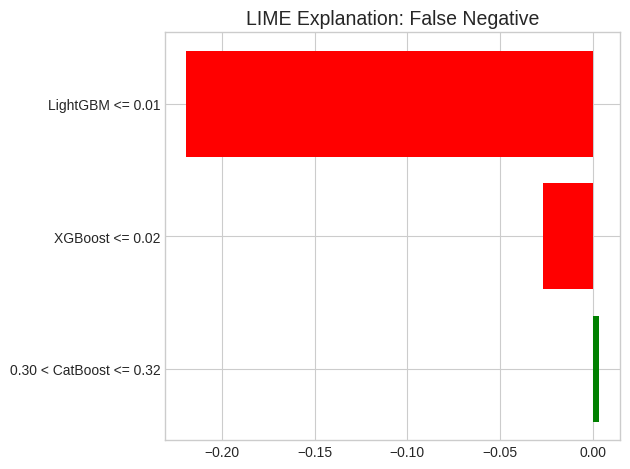

In [19]:
# Local Analysis: LIME Plots

for label, idx in selected_indices.items():
    print(f"\n{'='*50}")
    print(f"Case: {label} (Index: {idx})")
    print(f"Prediction: {results_df.loc[idx, 'Final_Pred']:.4f}")
    print(f"Actual: {results_df.loc[idx, 'Actual']}")
    
    # Get the instance data
    instance = meta_X_val.iloc[idx]
    
    # Generate LIME explanation
    # num_features=3 because we have 3 base models
    exp = explainer.explain_instance(
        data_row=instance.values, 
        predict_fn=predict_fn, 
        num_features=3
    )
    
    # Plot
    plt.figure(figsize=(10, 4))
    exp.as_pyplot_figure()
    plt.title(f"LIME Explanation: {label}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [16]:
print("Human-Readable Explanations for Selected Cases (LIME)")
print("="*60)

for label, idx in selected_indices.items():
    print(f"\nCASE: {label} (Index: {idx})")
    print(f"-"*30)
    
    # Get data
    instance = meta_X_val.iloc[idx]
    final_pred_prob = results_df.loc[idx, 'Final_Pred']
    
    # Generate explanation
    exp = explainer.explain_instance(
        data_row=instance.values, 
        predict_fn=predict_fn, 
        num_features=3
    )
    
    print(f"Predicted Risk for this Case: {final_pred_prob:.2%}")
    print(f"\nWhy this prediction?")
    
    # LIME returns a list of (feature_idx, weight) or (feature_name, weight) depending on how it's called
    # as_list() returns (feature_condition, weight)
    
    lime_list = exp.as_list()
    
    for feature_cond, weight in lime_list:
        # Determine impact description
        direction = "INCREASED" if weight > 0 else "DECREASED"
        
        # Simple magnitude heuristic
        abs_weight = abs(weight)
        if abs_weight < 0.05: strength = "Slightly"
        elif abs_weight < 0.15: strength = "Moderately"
        else: strength = "Strongly"
        
        print(f"  • {feature_cond} {strength} {direction} risk (Weight: {weight:.3f})")
        
    print("-" * 60)

Human-Readable Explanations for Selected Cases (LIME)

CASE: Highest Risk (Index: 252)
------------------------------
Intercept -0.010493802536296643
Prediction_local [0.70954644]
Right: 0.9999999999998403
Predicted Risk for this Case: 100.00%

Why this prediction?
  • LightGBM > 0.05 Strongly INCREASED risk (Weight: 0.665)
  • XGBoost > 0.09 Moderately INCREASED risk (Weight: 0.051)
  • 0.32 < CatBoost <= 0.34 Slightly INCREASED risk (Weight: 0.004)
------------------------------------------------------------

CASE: Lowest Risk (Index: 408)
------------------------------
Intercept 0.22955493106938574
Prediction_local [-0.0122849]
Right: 0.00043511588527454803
Predicted Risk for this Case: 0.04%

Why this prediction?
  • LightGBM <= 0.01 Strongly DECREASED risk (Weight: -0.220)
  • XGBoost <= 0.02 Slightly DECREASED risk (Weight: -0.023)
  • 0.32 < CatBoost <= 0.34 Slightly INCREASED risk (Weight: 0.002)
------------------------------------------------------------

CASE: False Positive

/home/wojtek/anaconda3/envs/ML2/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/wojtek/anaconda3/envs/ML2/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/wojtek/anaconda3/envs/ML2/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/wojtek/anaconda3/envs/ML2/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
